In [364]:
#!g1.4
# Import the libraries we are going to use
import glob
import os
from tqdm.auto import tqdm
from multiprocessing import Pool, cpu_count
import cv2
import time
import argparse
import logging
import numpy as np
import torch
from pathlib import Path
import shutil
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from timm.models import create_model, apply_test_time_pool
from timm.data import ImageDataset, create_loader, resolve_data_config
from timm.utils import AverageMeter, setup_default_logging
from timm.models.efficientnet import _cfg

In the following 2 cells we load 3k images covering around 10 minutes  of a football match.

The match is from validation video 3c993bd2_0 which we didn't use for training nor validation in our model.

We had this images splited and concated previously, to generate similar images please refer to the functions 'extract_images' and 'concate_images'
in model_testing notebook

Not much hardcoding in the demo but in order to have no bugs please follow 2 rules:


1. Pick frames from one video

In order to avoid data exploitation it's advised to use either '3c993bd2_0.mp4' or '3c993bd2_1.mp4' which we didn't use for training

2. Pick continous frames

In [4]:
#!g1.4
folder = 'work/extracted_images_train/'
files = os.listdir(folder)

In [65]:
#!c1.32
for i in range(7000,10000):
    file = f'3c993bd2_0-00{i}.jpg'
    src = 'work/extracted_images_train/' + file
    dst = 'work/demo_images/' + file
    shutil.copyfile(src, dst)
    if i % 100 == 0:
        print(f'Copied file number {i}')

Copied file number 7000
Copied file number 7100
Copied file number 7200
Copied file number 7300
Copied file number 7400
Copied file number 7500
Copied file number 7600
Copied file number 7700
Copied file number 7800
Copied file number 7900
Copied file number 8000
Copied file number 8100
Copied file number 8200
Copied file number 8300
Copied file number 8400
Copied file number 8500
Copied file number 8600
Copied file number 8700
Copied file number 8800
Copied file number 8900
Copied file number 9000
Copied file number 9100
Copied file number 9200
Copied file number 9300
Copied file number 9400
Copied file number 9500
Copied file number 9600
Copied file number 9700
Copied file number 9800
Copied file number 9900


The following function is used to process our model's predictions and clean them

In [109]:
#!g1.4
def make_sub(prob, filenames):
    
    frame_rate = 25
    window_size = 10
    ignore_width = 10
    group_count = 5

    df = pd.DataFrame(prob,columns=event_names_with_background)
    df['video_name'] = filenames
    df['video_id'] = df['video_name'].str.split('-').str[0]
    df['frame_id'] = df['video_name'].str.split('-').str[1].str.split('.').str[0].astype(int)

    train_df = pd.DataFrame()
    for video_id,gdf in df.groupby('video_id'):
        for i, event in enumerate(event_names):
            # Moving averages are used to smooth out the data.
            prob_arr = gdf[event].rolling(window=window_size, center=True).mean().fillna(-100).values
            gdf['rolling_prob'] = prob_arr
            sort_arr = np.argsort(-prob_arr)
            rank_arr = np.empty_like(sort_arr)
            rank_arr[sort_arr] = np.arange(len(sort_arr))
            # index list for detected action
            idx_list = []
            for i in range(len(prob_arr)):
                this_idx = sort_arr[i]
                if this_idx >= 0:
                    # Add maximam index to index_list
                    idx_list.append(this_idx)
                    for parity in (-1,1):
                        for j in range(1, ignore_width+1):
                            ex_idx = this_idx + j * parity
                            if ex_idx >= 0 and ex_idx < len(prob_arr):
                                # Exclude frames near this_idx where the action occurred. 
                                sort_arr[rank_arr[ex_idx]] = -1
            this_df = gdf.iloc[idx_list].reset_index(drop=True).reset_index().rename(columns={'index':'rank'})[['rank','video_id','frame_id']]
            this_df['event'] = event
            train_df = train_df.append(this_df)  
    
    train_df['time'] = train_df['frame_id']/25
    train_df['score'] = 1/(train_df['rank']+1)
    
    return train_df

The following function is copied from timm library and it's used to load weights for the model and create a data loader and make predictions

In [108]:
#!g1.4
#Source of the code: https://github.com/rwightman/pytorch-image-models/blob/main/inference.py
def inference(args):
    setup_default_logging()
    #args = parser.parse_args()
    #print(args)
    # might as well try to do something useful...
    args.pretrained = args.pretrained or not args.checkpoint

    # create model
    model = create_model(
        args.model,
        num_classes=args.num_classes,
        in_chans=3,
        pretrained=args.pretrained,
        checkpoint_path=args.checkpoint
    )
    
    
    _logger.info('Model %s created, param count: %d' %
                 (args.model, sum([m.numel() for m in model.parameters()])))

    config = resolve_data_config(vars(args), model=model)
    model, test_time_pool = (model, False) if args.no_test_pool else apply_test_time_pool(model, config)
    
    
    if args.num_gpu > 1:
        model = torch.nn.DataParallel(model, device_ids=list(range(args.num_gpu))).cuda()
    else:
        model = model.cuda()

    loader = create_loader(
        ImageDataset(args.data),
        input_size=config['input_size'],
        batch_size=args.batch_size,
        use_prefetcher=True,
        interpolation=config['interpolation'],
        mean=config['mean'],
        std=config['std'],
        num_workers=args.workers,
        crop_pct= 0.875)

    model.eval()

    k = min(args.topk, args.num_classes)
    batch_time = AverageMeter()
    end = time.time()
    prob = []
    with torch.no_grad():
        for batch_idx, (input, _) in enumerate(loader):
            input = input.cuda()
            labels = model(input)
            #import pdb;pdb.set_trace()
            #topk = labels.topk(k)[1]
            prob.append(labels.cpu().numpy())

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if batch_idx % args.log_freq == 0:
                _logger.info('Predict: [{0}/{1}] Time {batch_time.val:.3f} ({batch_time.avg:.3f})'.format(
                    batch_idx, len(loader), batch_time=batch_time))

    prob = np.concatenate(prob, axis=0)
    return prob, loader.dataset.filenames(basename=True)

Create args for our model (contains trained weights)

In [106]:
#!g1.4
class args:
    batch_size=16
    workers=4
    checkpoint='model/tf_efficientnet_b0_ap-456-fix.pt'
    data='work/demo_images/'
    img_size=(1280, 720)
    input_size=(3, 1280, 720)
    interpolation=''
    log_freq=500
    mean=None
    model='tf_efficientnet_b0_ap'
    no_test_pool=False
    num_classes=4
    num_gpu=1
    output_dir='/tmp/ph2'
    pretrained=False
    std=None
    topk=5

Make predictions

In [110]:
#!g1.4
prob, filenames = inference(args)

Loaded  from checkpoint 'model/tf_efficientnet_b0_ap-456-fix.pt'
Model tf_efficientnet_b0_ap created, param count: 4012672
Target input size (1280, 720) > pretrained default (224, 224), using test time pooling
Predict: [0/188] Time 2.179 (2.179)


Process the predictions

In [342]:
#!g1.4
pred = make_sub(prob, filenames)

<ipython-input-2-f3f6a0c8dc1f>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(this_df)
<ipython-input-2-f3f6a0c8dc1f>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(this_df)
<ipython-input-2-f3f6a0c8dc1f>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(this_df)


Load correct annotations

In [140]:
#!g1.4
solution = pd.read_csv("dfl-bundesliga-data-shootout/train.csv")
solution = solution[solution['video_id'].isin(pred['video_id'].unique())]
solution = solution[(solution['time'] < pred['time'].max()) & (solution['time'] > pred['time'].min())]

In [343]:
#!g1.4
pred = pred.sort_values(by=['time'])
pred

rank    video_id  frame_id      event    time     score
221   221  3c993bd2_0      7000  challenge  280.00  0.004505
91     91  3c993bd2_0      7005    throwin  280.20  0.010870
137   137  3c993bd2_0      7006       play  280.24  0.007246
9       9  3c993bd2_0      7011  challenge  280.44  0.100000
64     64  3c993bd2_0      7018    throwin  280.72  0.015385
..    ...         ...       ...        ...     ...       ...
167   167  3c993bd2_0      9981       play  399.24  0.005952
17     17  3c993bd2_0      9988    throwin  399.52  0.055556
19     19  3c993bd2_0      9990  challenge  399.60  0.050000
60     60  3c993bd2_0      9995       play  399.80  0.016393
214   214  3c993bd2_0      9999    throwin  399.96  0.004651

[656 rows x 6 columns]

In [142]:
#!g1.4
solution.sort_values(by=['time'])

video_id        time      event        event_attributes
4283  3c993bd2_0  280.060000       play    ['pass', 'openplay']
4284  3c993bd2_0  281.111851        end                     NaN
4285  3c993bd2_0  284.425933      start                     NaN
4286  3c993bd2_0  285.180000       play    ['pass', 'openplay']
4287  3c993bd2_0  286.925933        end                     NaN
4288  3c993bd2_0  293.432541      start                     NaN
4289  3c993bd2_0  294.420000       play    ['pass', 'openplay']
4290  3c993bd2_0  295.932541        end                     NaN
4291  3c993bd2_0  296.893514      start                     NaN
4292  3c993bd2_0  297.420000  challenge              ['fouled']
4293  3c993bd2_0  299.393514        end                     NaN
4294  3c993bd2_0  318.480761      start                     NaN
4295  3c993bd2_0  320.460000       play    ['pass', 'freekick']
4296  3c993bd2_0  322.540000       play    ['pass', 'openplay']
4297  3c993bd2_0  323.471526        end                     NaN
4298  3c993bd2_0  324.994371      start                     NaN
4299  3c993bd2_0  327.060000       play    ['pass', 'openplay']
4300  3c993bd2_0  327.494371        end                     NaN
4301  3c993bd2_0  332.655454      start                     NaN
4302  3c993bd2_0  333.340000       play    ['pass', 'openplay']
4303  3c993bd2_0  335.155454        end                     NaN
4304  3c993bd2_0  336.922866      start                     NaN
4305  3c993bd2_0  337.700000       play    ['pass', 'openplay']
4306  3c993bd2_0  339.422866        end                     NaN
4307  3c993bd2_0  339.639021      start                     NaN
4308  3c993bd2_0  340.260000       play    ['pass', 'openplay']
4309  3c993bd2_0  342.139021        end                     NaN
4310  3c993bd2_0  342.147500      start                     NaN
4311  3c993bd2_0  342.580000       play    ['pass', 'openplay']
4312  3c993bd2_0  344.647500        end                     NaN
4313  3c993bd2_0  349.107361      start                     NaN
4314  3c993bd2_0  349.660000       play    ['pass', 'openplay']
4315  3c993bd2_0  351.607361        end                     NaN
4316  3c993bd2_0  352.540991      start                     NaN
4317  3c993bd2_0  353.020000       play    ['pass', 'openplay']
4318  3c993bd2_0  355.420000       play    ['pass', 'openplay']
4319  3c993bd2_0  356.109239        end                     NaN
4320  3c993bd2_0  357.567866      start                     NaN
4321  3c993bd2_0  358.580000       play    ['pass', 'openplay']
4322  3c993bd2_0  360.067866        end                     NaN
4323  3c993bd2_0  360.083701      start                     NaN
4324  3c993bd2_0  361.940000       play    ['pass', 'openplay']
4325  3c993bd2_0  362.583701        end                     NaN
4326  3c993bd2_0  364.325937      start                     NaN
4327  3c993bd2_0  364.820000       play    ['pass', 'openplay']
4328  3c993bd2_0  367.580000       play    ['pass', 'openplay']
4329  3c993bd2_0  368.867142        end                     NaN
4330  3c993bd2_0  369.104925      start                     NaN
4331  3c993bd2_0  370.500000  challenge  ['ball_action_forced']
4332  3c993bd2_0  372.420000  challenge  ['ball_action_forced']
4333  3c993bd2_0  373.696302        end                     NaN
4334  3c993bd2_0  390.535456      start                     NaN
4335  3c993bd2_0  391.860000    throwin                ['pass']
4336  3c993bd2_0  393.035456        end                     NaN
4337  3c993bd2_0  393.214969      start                     NaN
4338  3c993bd2_0  394.340000       play    ['pass', 'openplay']
4339  3c993bd2_0  395.714969        end                     NaN
4340  3c993bd2_0  395.791943      start                     NaN
4341  3c993bd2_0  397.860000       play    ['pass', 'openplay']
4342  3c993bd2_0  398.291943        end                     NaN

In [171]:
#!g1.4
events = (solution.query("event not in ['start', 'end']"))
events

video_id    time      event        event_attributes
4283  3c993bd2_0  280.06       play    ['pass', 'openplay']
4286  3c993bd2_0  285.18       play    ['pass', 'openplay']
4289  3c993bd2_0  294.42       play    ['pass', 'openplay']
4292  3c993bd2_0  297.42  challenge              ['fouled']
4295  3c993bd2_0  320.46       play    ['pass', 'freekick']
4296  3c993bd2_0  322.54       play    ['pass', 'openplay']
4299  3c993bd2_0  327.06       play    ['pass', 'openplay']
4302  3c993bd2_0  333.34       play    ['pass', 'openplay']
4305  3c993bd2_0  337.70       play    ['pass', 'openplay']
4308  3c993bd2_0  340.26       play    ['pass', 'openplay']
4311  3c993bd2_0  342.58       play    ['pass', 'openplay']
4314  3c993bd2_0  349.66       play    ['pass', 'openplay']
4317  3c993bd2_0  353.02       play    ['pass', 'openplay']
4318  3c993bd2_0  355.42       play    ['pass', 'openplay']
4321  3c993bd2_0  358.58       play    ['pass', 'openplay']
4324  3c993bd2_0  361.94       play    ['pass', 'openplay']
4327  3c993bd2_0  364.82       play    ['pass', 'openplay']
4328  3c993bd2_0  367.58       play    ['pass', 'openplay']
4331  3c993bd2_0  370.50  challenge  ['ball_action_forced']
4332  3c993bd2_0  372.42  challenge  ['ball_action_forced']
4335  3c993bd2_0  391.86    throwin                ['pass']
4338  3c993bd2_0  394.34       play    ['pass', 'openplay']
4341  3c993bd2_0  397.86       play    ['pass', 'openplay']

In [385]:
#!g1.4
len(events)

23

Since our model made much more predictions than it should do we filter the predictions

If we have 2 events which happens in less than 5 seconds we pick the one with a higher score, we picked 5 as a threshold because there are about 5 seconds on average between each two events in the original annotation

In [344]:
#!g1.4
times = pred['time'].to_numpy()
scores = pred['score'].to_numpy()
classes = pred['event'].to_numpy()
frames = pred['frame_id'].to_numpy()

In [345]:
#!g1.4
indx_del = []
for i in range(len(times)):
    for j in range(i+1, len(times)):
        if abs(times[i] - times[j]) < 5 and classes[i] == classes[j]:
            if scores[i] > scores[j]:
                indx_del.append(j)
            else:
                indx_del.append(i)

In [346]:
#!g1.4
filtered_pred = []
for i in range(len(times)):
    if i not in indx_del:
        temp = []
        temp.append(times[i])
        temp.append(classes[i])
        temp.append(frames[i])
        temp.append(scores[i])
        filtered_pred.append(temp)
        

In [347]:
#!g1.4
filtered_pred = pd.DataFrame(filtered_pred, columns = ['time','event','fram_id','score'])
filtered_pred

time      event  fram_id     score
0   280.44  challenge     7011  0.100000
1   282.00       play     7050  0.052632
2   282.08    throwin     7052  0.032258
3   287.92  challenge     7198  0.142857
4   289.68    throwin     7242  0.050000
5   291.44       play     7286  0.076923
6   296.60  challenge     7415  0.250000
7   297.36       play     7434  0.028571
8   298.60    throwin     7465  0.041667
9   308.08    throwin     7702  0.045455
10  318.12  challenge     7953  0.031250
11  322.44    throwin     8061  0.071429
12  327.12       play     8178  0.500000
13  331.52    throwin     8288  0.333333
14  335.40  challenge     8385  0.090909
15  340.24       play     8506  0.166667
16  341.28  challenge     8532  0.200000
17  342.52    throwin     8563  0.029412
18  345.48       play     8637  0.333333
19  346.96  challenge     8674  1.000000
20  353.12       play     8828  1.000000
21  353.12    throwin     8828  0.500000
22  358.12  challenge     8953  0.062500
23  359.04    throwin     8976  0.066667
24  366.04       play     9151  0.058824
25  370.60  challenge     9265  0.500000
26  372.28    throwin     9307  1.000000
27  376.88  challenge     9422  0.025000
28  380.12       play     9503  0.200000
29  382.48    throwin     9562  0.250000
30  385.20  challenge     9630  0.076923
31  387.24       play     9681  0.250000
32  390.76    throwin     9769  0.200000
33  394.40       play     9860  0.038462
34  398.88  challenge     9972  0.166667
35  399.80       play     9995  0.016393

In [348]:
#!g1.4
pred = filtered_pred
len(pred)

36

In [349]:
#!g1.4
len(events)

23

We test our model as a classes classifier which means that we check if our model predict that there are an event regardless of the correctness of the prediction

In [350]:
#!g1.4
# Evaluation metric as a 2 classes classifier with tolerance as 5 second
correct = 0
total = 0
for ind in events.index:
    event_time = events['time'][ind]
    event_type = events['event'][ind]
    predictions = pred[(pred['time'] > event_time - 2.5) & (pred['time'] < event_time + 2.5)]
    if len(predictions) > 0:
        correct += 1
    total +=1
print(correct/total)

0.8695652173913043


We test our model as a 4 classes classifier

In [353]:
#!g1.4
# Evaluation emtric as a 4 classes classifier with tolerance as 5 second
correct = 0
total = 0
display = []
for ind in events.index:
    event_time = events['time'][ind]
    event_type = events['event'][ind]
    predictions = pred[(pred['time'] > event_time - 2.5) & (pred['time'] < event_time + 2.5)]
    predictions = predictions[predictions['event'].eq(event_type)]
    if len(predictions) > 0:
        correct += 1
    total +=1
print(correct/total)

0.6086956521739131


Text(0.5, 1.0, 'Correctly predicted as a play')

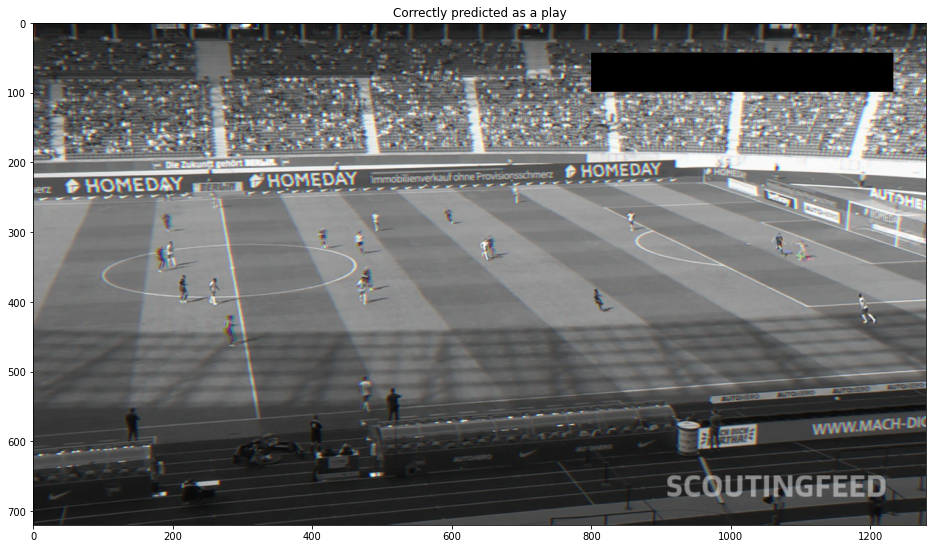

In [380]:
#!g1.4
filepath = 'work/demo_images/'
img = cv2.imread(filepath + '3c993bd2_0-008178.jpg')
figure(figsize=(16, 12))
plt.imshow(img)
plt.title("Correctly predicted as a play")

Text(0.5, 1.0, 'Same play')

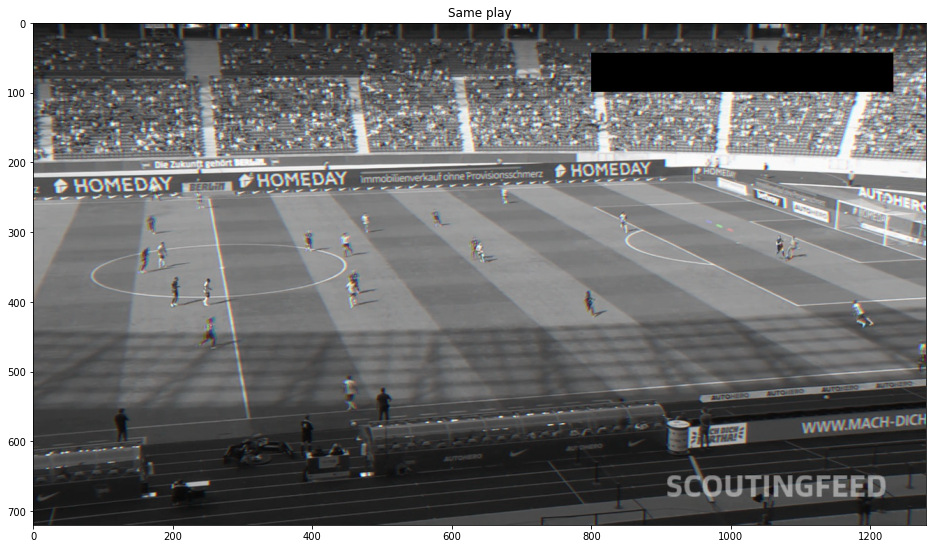

In [384]:
#!g1.4
img = cv2.imread(filepath + '3c993bd2_0-008185.jpg')
figure(figsize=(16, 12))
plt.imshow(img)
plt.title("Same play")

Text(0.5, 1.0, 'Correctly Predicted as a play')

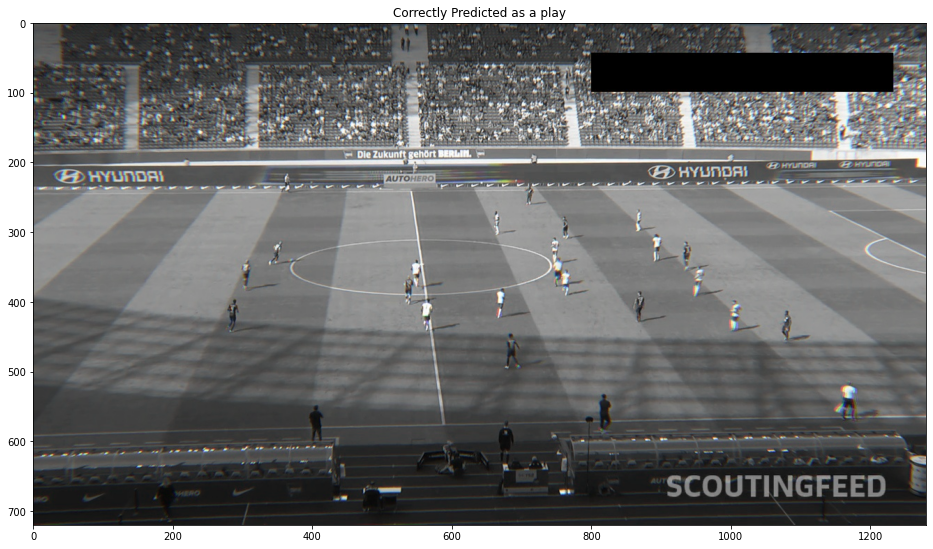

In [367]:
#!g1.4
img = cv2.imread(filepath + '3c993bd2_0-007050.jpg')
figure(figsize=(16, 12))
plt.imshow(img)
plt.title('Correctly Predicted as a play')

Text(0.5, 1.0, "Predicted as a challenge where it's a play")

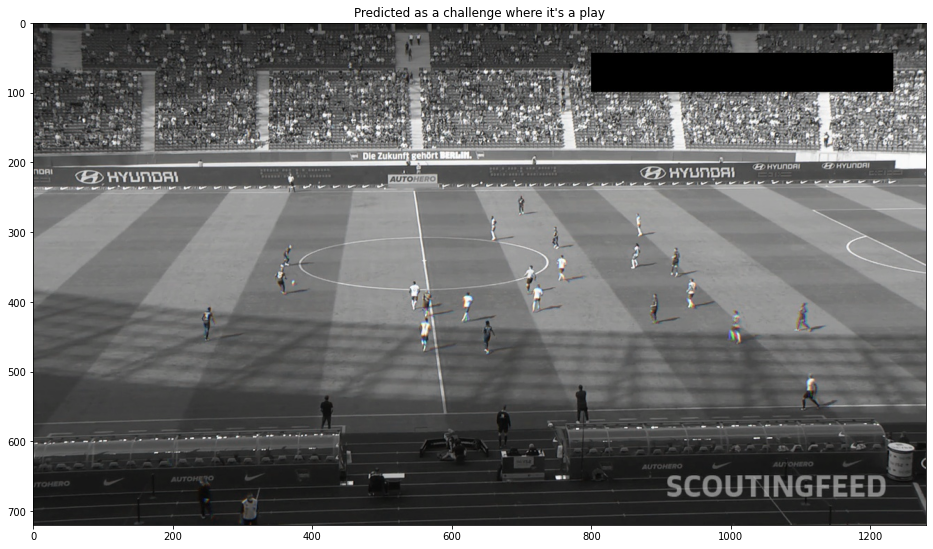

In [369]:
#!g1.4
img = cv2.imread(filepath + '3c993bd2_0-007011.jpg')
figure(figsize=(16, 12))
plt.imshow(img)
plt.title("Predicted as a challenge where it's a play")

Text(0.5, 1.0, 'Correctly predicted as a throwin')

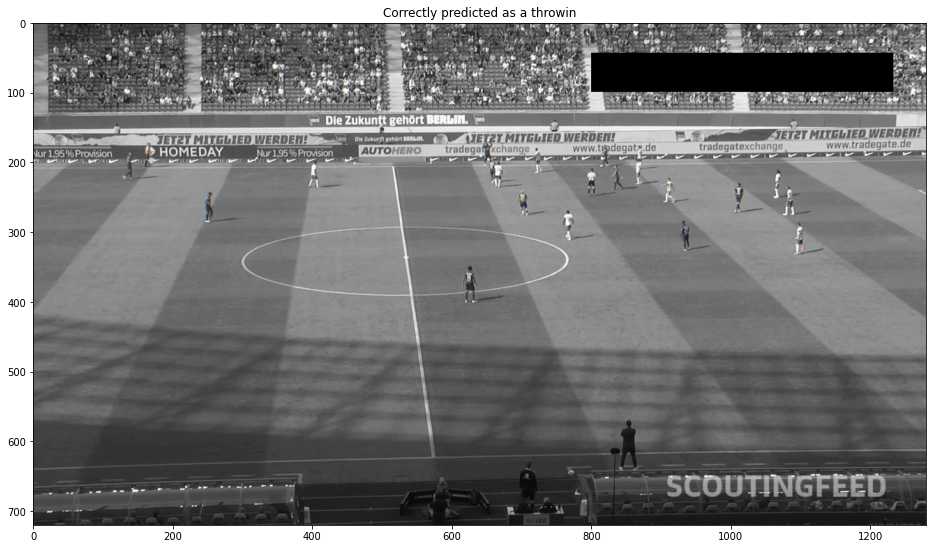

In [370]:
#!g1.4
img = cv2.imread(filepath + '3c993bd2_0-009769.jpg')
figure(figsize=(16, 12))
plt.imshow(img)
plt.title("Correctly predicted as a throwin")

Text(0.5, 1.0, "It's as a challenge (foul) but our model missed it")

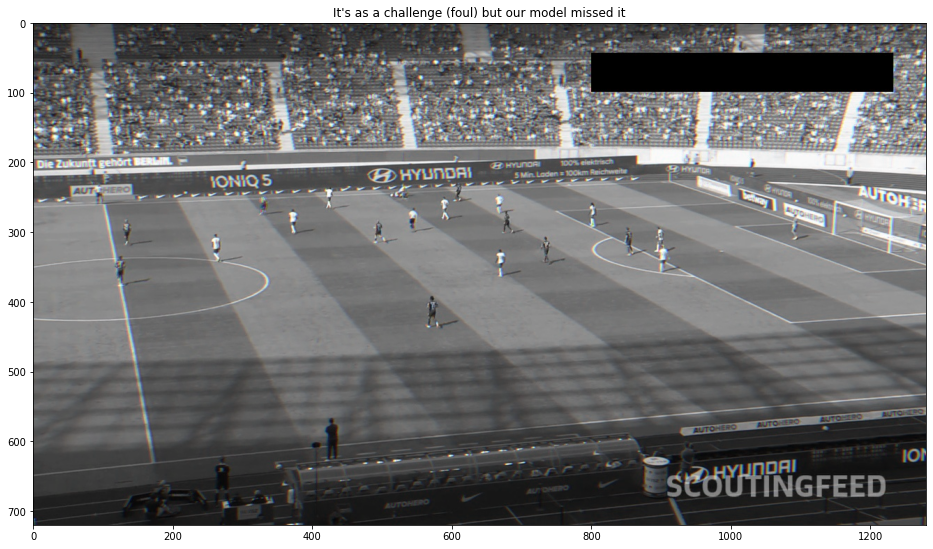

In [374]:
#!g1.4
img = cv2.imread(filepath + '3c993bd2_0-007437.jpg')
figure(figsize=(16, 12))
plt.imshow(img)
plt.title("It's as a challenge (foul) but our model missed it")

Text(0.5, 1.0, "It's as a challenge (ball action forced) but our model classified it as a throwin")

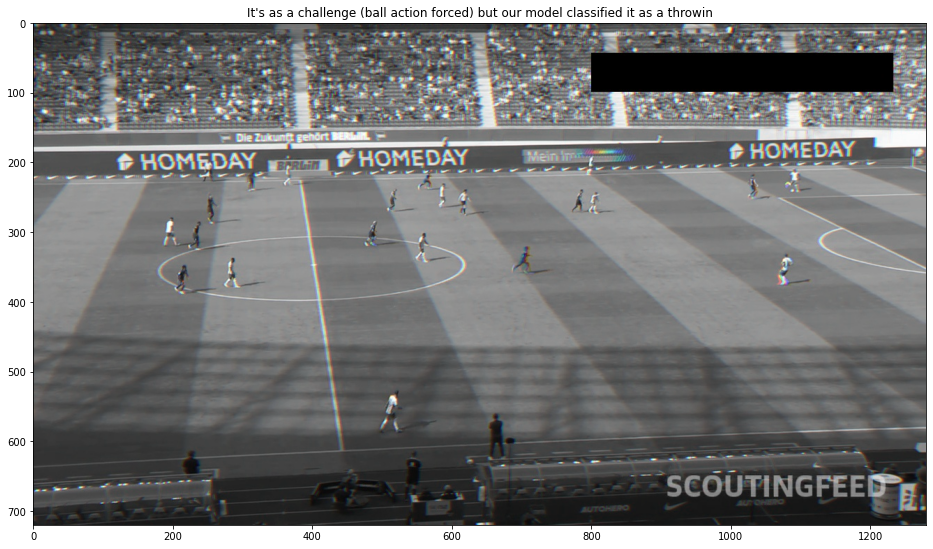

In [375]:
#!g1.4
img = cv2.imread(filepath + '3c993bd2_0-008061.jpg')
figure(figsize=(16, 12))
plt.imshow(img)
plt.title("It's as a challenge (ball action forced) but our model classified it as a throwin")
# we think that our model misclassified this event because of the movements on the advertising panel which looks like a throwin